In [69]:
import numpy as np
import torch
from torch.utils.dlpack import to_dlpack
import cupy as cu
from cupyx import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [5]:
%matplotlib inline

In [6]:
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
mpl.rc('figure', figsize = (32,16))

In [7]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

cu.cuda.Device(1).use()
device

'cuda:1'

In [116]:
import pandas as pd
import numpy as np
import os

DATA_DIR = "data"
salt = 'hackathon-three-cities_'
l1_nrows = 1512
l2_nrows = 1248
n_horizons = 4
y_height = 3001

# Загружаем значения высот в узлах сетки для срезов L1 и L2

all_data_l1 = np.load(os.path.join(DATA_DIR, salt+"all_data_L1.npy"))
all_data_l2 = np.load(os.path.join(DATA_DIR, salt+"all_data_L2.npy"))

assert all_data_l1.shape == (l1_nrows, y_height), "Неправильный размер all_data_L1.npy"
assert all_data_l2.shape == (l2_nrows, y_height), "Неправильный размер all_data_L2.npy"

# Загружаем горизонты

l1_horizons_train = pd.read_csv(os.path.join(DATA_DIR, salt+"L1_horizons_train.csv"))
l2_horizons_train = pd.read_csv(os.path.join(DATA_DIR, salt+"L2_horizons_train.csv"))

assert l1_horizons_train.shape == (l1_nrows, n_horizons+1)
assert l2_horizons_train.shape == (l2_nrows, n_horizons+1)

sample_submission = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
my_submission = sample_submission.copy()

In [200]:
data = all_data_l1.T[600:1000, 521:1451]
data = data - data.min()
data = data / data.max()
data *= 400

In [201]:
start_point = [0, 213]


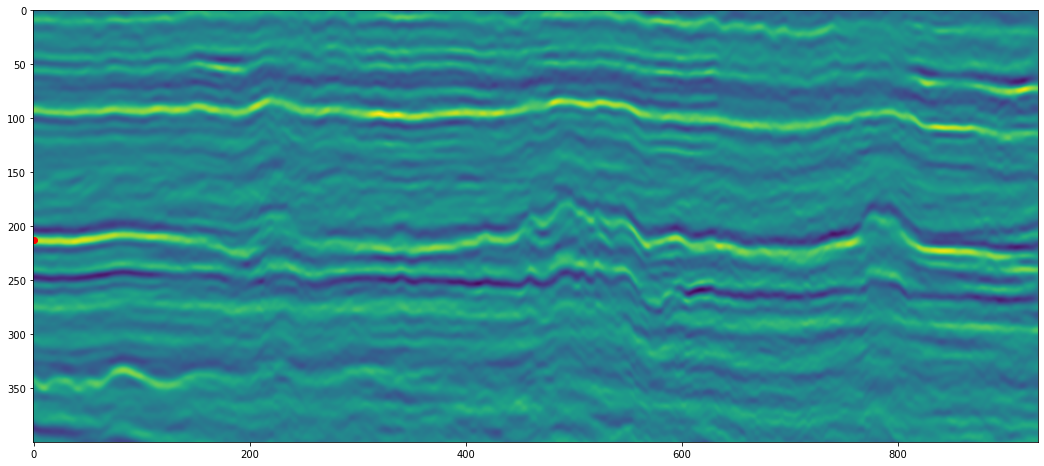

In [202]:
plt.imshow(data)
plt.scatter([start_point[0]],[start_point[1]], color='red')

In [203]:
arr = torch.tensor(data, device=device, dtype=torch.float32)
W = data.shape[1]
H = data.shape[0]
N = W * H

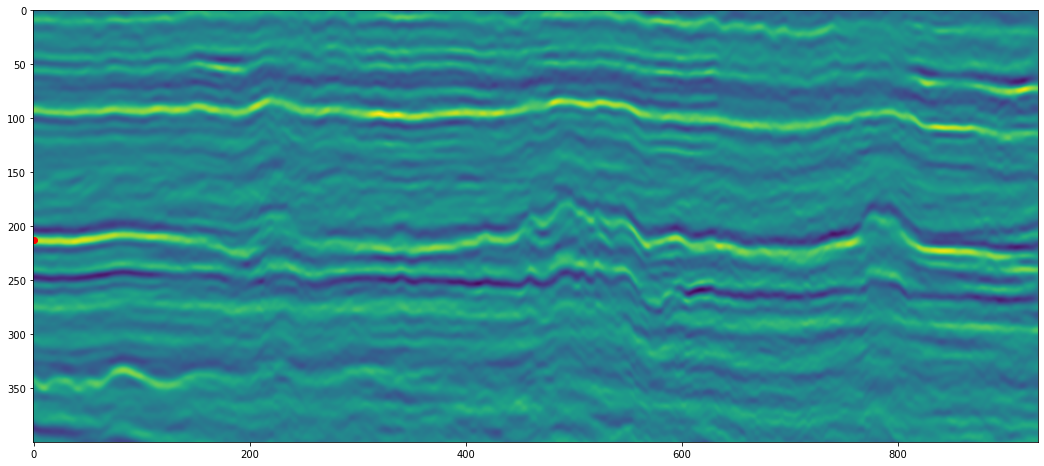

In [204]:
plt.imshow(arr.cpu().numpy())
plt.scatter([start_point[0]],[start_point[1]], color='red')

In [205]:
cust_filter = torch.tensor([[[0, 1, 0], [0, -1, 0], [0, 0, 0]], 
                            [[0, 0, 0], [0, -1, 1], [0, 0, 0]],
                            [[0, 0, 0], [0, -1, 0], [0, 1, 0]],
                            [[0, 0, 0], [1, -1, 0], [0, 0, 0]]], device=device, dtype=torch.float32)

In [206]:
cust_filter, cust_filter.shape

(tensor([[[ 0.,  1.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  1.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0., -1.,  0.],
          [ 0.,  1.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 1., -1.,  0.],
          [ 0.,  0.,  0.]]], device='cuda:1'),
 torch.Size([4, 3, 3]))

In [207]:
vectors = torch.nn.functional.conv2d(input=arr[None, None, ...], weight=cust_filter[:, None], padding=1)
vectors = vectors[0]
vectors[0, 0, :] = 0
vectors[1, :, -1] = 0
vectors[2, -1, :] = 0
vectors[3, :, 0] = 0
vectors, vectors.shape

(tensor([[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [ -7.8307,  -7.6946,  -6.7758,  ...,   6.5692,   5.4948,   5.3468],
          [-11.5692, -11.1990, -10.3563,  ...,   2.5399,   3.1208,   3.5660],
          ...,
          [ -0.5934,  -2.8105,  -5.4480,  ...,  -6.5527,  -5.5519,  -4.8845],
          [  1.8480,  -0.2515,  -1.6167,  ...,  -0.6059,  -0.4934,   0.0725],
          [  2.0780,   1.7424,   1.0480,  ...,   5.8420,   5.0780,   5.2134]],
 
         [[ -0.7493,  -0.0877,  -0.0609,  ...,   2.0497,   3.8196,   0.0000],
          [ -0.8853,  -1.0064,  -0.3972,  ...,   3.1240,   3.9676,   0.0000],
          [ -1.2555,  -1.8492,  -0.6830,  ...,   2.5432,   3.5223,   0.0000],
          ...,
          [ -0.4402,  -0.1528,  -0.5469,  ...,  -3.3541,  -3.2822,   0.0000],
          [  1.6592,   1.2124,   1.0353,  ...,  -3.4666,  -3.8480,   0.0000],
          [  1.9949,   1.9068,   2.2692,  ...,  -2.7027,  -3.9834,   0.0000]],
 
         [[  7.8307,   7.694

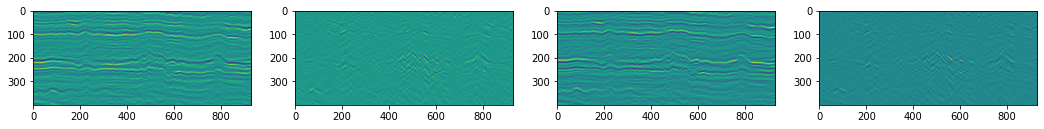

In [208]:
plt.rcParams['figure.figsize'] = [18, 12]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(vectors[i].cpu().numpy())

In [209]:
square = torch.ones_like(vectors)
square[:-1] += vectors[:-1] ** 2 + vectors[1:] ** 2
square[-1] +=  vectors[0] ** 2 + vectors[-1] ** 2
square = torch.sqrt(square) / 2

In [210]:
square, square.shape

(tensor([[[0.6248, 0.5019, 0.5009,  ..., 1.1403, 1.9742, 0.5000],
          [3.9719, 3.9122, 3.4304,  ..., 3.6713, 3.4255, 2.7198],
          [5.8400, 5.6973, 5.2134,  ..., 1.8654, 2.4055, 1.8518],
          ...,
          [0.6217, 1.4935, 2.7830,  ..., 3.7144, 3.2633, 2.4929],
          [1.3387, 0.7958, 1.0823,  ..., 1.8293, 2.0032, 0.5013],
          [1.5246, 1.3849, 1.3461,  ..., 3.2570, 3.2655, 2.6542]],
 
         [[3.9649, 3.8799, 3.4248,  ..., 3.4769, 3.3831, 2.7198],
          [5.8230, 5.6443, 5.2060,  ..., 2.0743, 2.5730, 1.8518],
          [7.6369, 7.4100, 7.0348,  ..., 1.3691, 1.8764, 1.0286],
          ...,
          [1.0734, 0.5212, 0.9890,  ..., 1.7760, 1.7332, 0.5013],
          [1.4205, 1.1732, 0.8902,  ..., 3.4332, 3.2247, 2.6542],
          [1.1158, 1.0765, 1.2399,  ..., 1.4409, 2.0535, 0.5000]],
 
         [[3.9471, 3.8977, 3.4249,  ..., 3.3226, 2.9747, 3.3233],
          [5.8061, 5.6392, 5.2265,  ..., 1.4525, 2.2638, 2.7138],
          [7.6111, 7.3789, 7.0871,  ...,

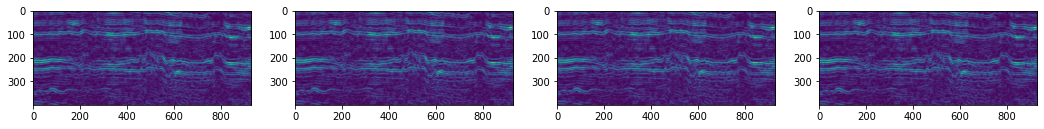

In [211]:
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(square[i].cpu().numpy())

In [212]:
square[0, 0, :] = 0
square[1, :, -1] = 0
square[2, -1, :] = 0
square[3, :, 0] = 0

In [213]:
vertex_area = square.sum(axis=0)

In [214]:
vertex_area, vertex_area.shape

(tensor([[ 7.9120,  8.4024,  7.3516,  ...,  7.3003,  7.4981,  5.2975],
         [15.6010, 19.1005, 17.3243,  ..., 10.5576, 11.4619,  8.7999],
         [21.0880, 26.1430, 24.6191,  ...,  5.4746,  7.7829,  6.4469],
         ...,
         [ 2.7457,  4.0830,  7.4961,  ...,  9.6442, 10.0453,  7.1934],
         [ 3.9122,  4.2485,  4.0444,  ...,  9.1777, 10.1632,  5.7678],
         [ 2.6404,  3.8770,  3.7832,  ...,  7.6928,  8.2384,  5.9726]],
        device='cuda:1'),
 torch.Size([400, 930]))

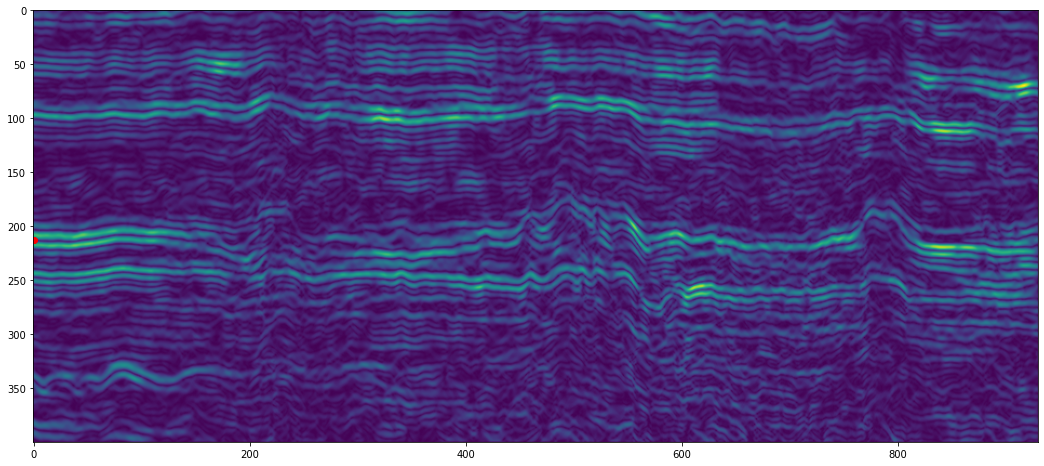

In [216]:
plt.imshow(vertex_area.cpu().numpy())
plt.scatter([start_point[0]],[start_point[1]], color='red')

In [217]:
del square, arr
torch.cuda.empty_cache()

In [218]:
cotangens = torch.zeros_like(vectors)
cotangens[0] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[0] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[0]) / (torch.sqrt(2 + (vectors[0] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[1] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[1] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[1]) / (torch.sqrt(2 + (vectors[1] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[2] = 1 / torch.tan(torch.acos((1 + vectors[3] ** 2 - vectors[3] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[3]) ** 2) * torch.sqrt(1 + vectors[3] ** 2))))
cotangens[2] += 1 / torch.tan(torch.acos((1 + vectors[1] ** 2 - vectors[1] * vectors[2]) / (torch.sqrt(2 + (vectors[2] - vectors[1]) ** 2) * torch.sqrt(1 + vectors[1] ** 2))))

cotangens[3] = 1 / torch.tan(torch.acos((1 + vectors[0] ** 2 - vectors[0] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[0]) ** 2) * torch.sqrt(1 + vectors[0] ** 2))))
cotangens[3] += 1 / torch.tan(torch.acos((1 + vectors[2] ** 2 - vectors[2] * vectors[3]) / (torch.sqrt(2 + (vectors[3] - vectors[2]) ** 2) * torch.sqrt(1 + vectors[2] ** 2))))

cotangens[0, 0, :] = 0
cotangens[1, :, -1] = 0
cotangens[2, -1, :] = 0
cotangens[3, :, 0] = 0

In [219]:
main_i = torch.arange(end=N, device=device)
upper_edge_i = torch.arange(start=W, end=N, device=device)
right_edge_i = main_i[cotangens[1].view(-1) != 0]
left_edge_i = main_i[cotangens[3].view(-1) != 0]
down_edge_i = torch.arange(start=0, end=N-W, device=device)

In [220]:
main_v = cotangens.sum(axis=0).view(-1)
upper_edge_v = cotangens[0].view(-1)[upper_edge_i]
right_edge_v = cotangens[1].view(-1)[right_edge_i]
down_edge_v = cotangens[2].view(-1)[down_edge_i]
left_edge_v = cotangens[3].view(-1)[left_edge_i]

In [221]:
# cu.cuda.Device(0).use()

main_v = cu.fromDlpack(to_dlpack(main_v))
main_i = cu.fromDlpack(to_dlpack(main_i))

upper_edge_v = cu.fromDlpack(to_dlpack(upper_edge_v))
upper_edge_i = cu.fromDlpack(to_dlpack(upper_edge_i))

right_edge_v = cu.fromDlpack(to_dlpack(right_edge_v))
right_edge_i = cu.fromDlpack(to_dlpack(right_edge_i))

down_edge_v = cu.fromDlpack(to_dlpack(down_edge_v))
down_edge_i = cu.fromDlpack(to_dlpack(down_edge_i))


left_edge_v = cu.fromDlpack(to_dlpack(left_edge_v))
left_edge_i = cu.fromDlpack(to_dlpack(left_edge_i))

In [222]:
upper_m = scipy.sparse.coo_matrix((upper_edge_v / 2, (upper_edge_i, main_i[:-W])), shape=(N, N))
right_m = scipy.sparse.coo_matrix((right_edge_v / 2, (right_edge_i, right_edge_i + 1)), shape=(N, N))
down_m = scipy.sparse.coo_matrix((down_edge_v / 2, (down_edge_i, main_i[W:])), shape=(N, N))
left_m = scipy.sparse.coo_matrix((left_edge_v / 2, (left_edge_i, left_edge_i - 1)), shape=(N, N))
main_m = scipy.sparse.diags(-main_v / 2)

In [223]:
L = main_m + upper_m + right_m + down_m + left_m

In [224]:
M = scipy.sparse.diags(cu.fromDlpack(to_dlpack(vertex_area.view(-1) / 3)))

In [225]:
M.dtype, L.dtype

(dtype('float32'), dtype('float32'))

In [233]:
del main_m, upper_m, right_m, down_m, left_m
del vertex_area
del main_v, main_i, upper_edge_v, upper_edge_i, right_edge_v, right_edge_i, down_edge_v, down_edge_i, left_edge_v, left_edge_i
torch.cuda.empty_cache()

NameError: name 'main_m' is not defined

In [232]:
b = cu.zeros(N, dtype=cu.float32)
b[start_point[1] * W + start_point[0]] = 1
# b[3*W+20] = 1
b.dtype

dtype('float32')

24.46961283683777

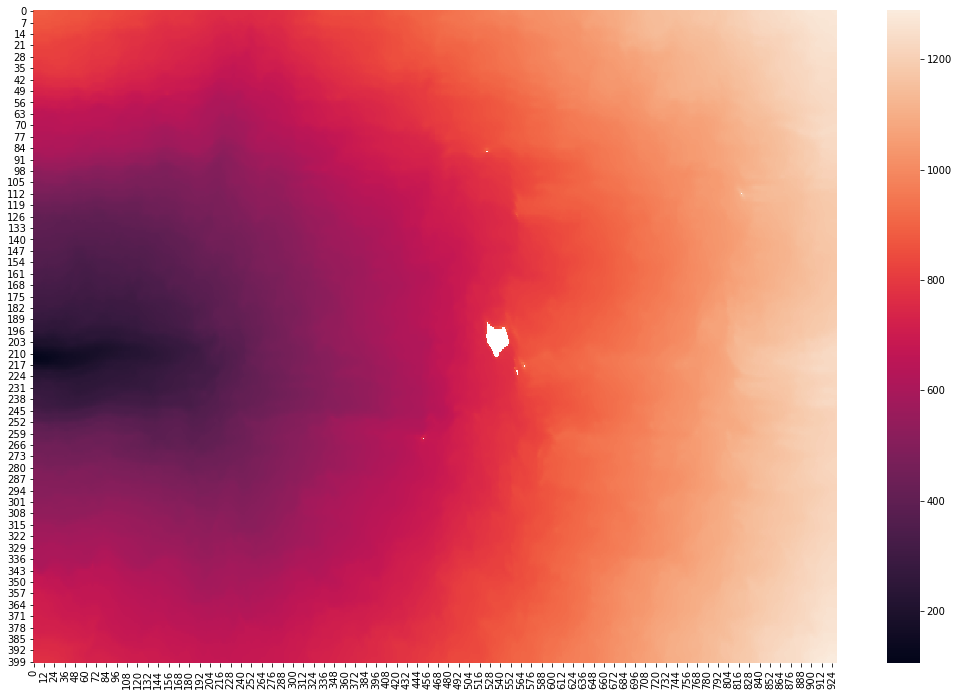

In [236]:
start = time.time()
T = 350
u = scipy.sparse.linalg.lsqr(M - T * L, b)
u = u[0]
sns.heatmap(cu.asnumpy((-T ** 0.5 * cu.log(u)).reshape(H, W)))
end = time.time()
end - start

In [237]:
s = cu.asnumpy((-T ** 0.5 * cu.log(u)).reshape(H, W))

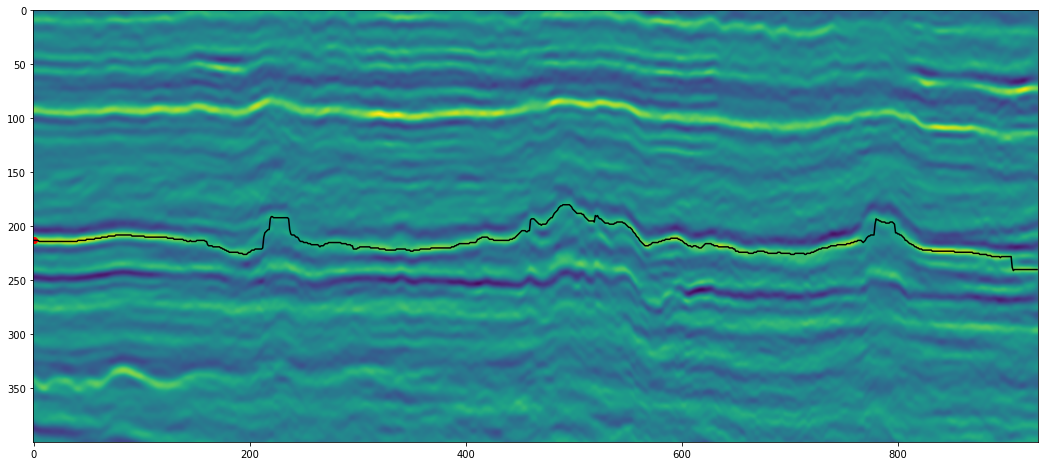

In [245]:
plt.imshow(data)
plt.scatter([start_point[0]],[start_point[1]], color='red')
plt.plot(df.y-600, color='black')

In [241]:
df = pd.read_csv('my_submission_evrstc21.csv')

In [253]:
end_point = [s.shape[1]-1, np.argmin(s[:, -1])]

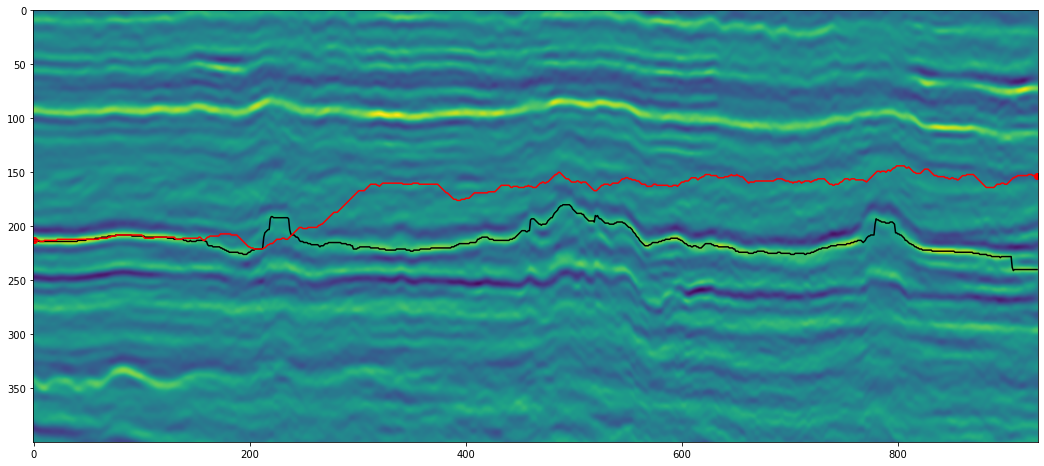

In [275]:
plt.imshow(s)
plt.imshow(data)
plt.scatter([start_point[0]],[start_point[1]], color='red')
plt.scatter([end_point[0]],[end_point[1]], color='red' )
plt.plot(df.y-600, color='black')
plt.plot(y_hat, color='red')

In [265]:
y_hat = [end_point[1]]

In [266]:
y_hat

[153]

In [267]:
i,j = end_point[1],end_point[0]

In [268]:
while j!= 0:
    neighbours = np.array([s[i-1,j-1],
                            s[i,j-1],
                           s[i+1,j-1]])

                          
    upd = np.argmin(neighbours)
    i += (upd - 1)
    j -= 1
    y_hat.append(i)
    

In [269]:
y_hat=np.array(y_hat)

In [260]:
x = np.arange(s.shape[1]-1, s.shape[1]-1-len(y_hat),-1)

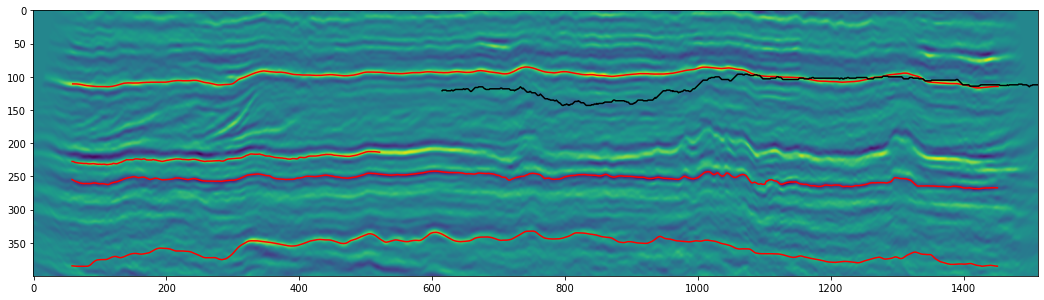

In [184]:
plt.imshow(all_data_l1.T[600:1000])
plt.plot(l1_horizons_train.hor_1-600, color='red')
plt.plot(l1_horizons_train.hor_2-600, color='red')

plt.plot(x+400, y_hat, color='black')


plt.plot(l1_horizons_train.hor_3-600, color='red')
plt.plot(l1_horizons_train.hor_4-600, color='red')

In [274]:
y_hat = y_hat[::-1]

In [177]:
len(y_hat)

897

In [ ]:
plt.plot

In [162]:
len(s[:, -1])

400

In [276]:
my_submission.x.shape

(930,)

In [277]:
y_hat.shape

(930,)

In [278]:
my_submission.y = y_hat+600

In [279]:
my_submission.to_csv('heat_method.csv', index=0)

# u = scipy.sparse.linalg.lsqr(M - L, b)
# u = u[0]
start = time.time()

for i in range(4):
    u = scipy.sparse.linalg.lsqr(M - (0.1 +  TTT * i) * L, b)
    u = u[0]
    plt.subplot(2, 2, 1 + i)
    sns.heatmap(cu.asnumpy((-(0.1 +  TTT * i) ** 0.5 * cu.log(u)).reshape(H, W)))

end = time.time()
end - start
#     del u
#     torch.cuda.empty_cache()

(u == 0).sum(), u.shape[0]

# _ = plt.hist(cu.asnumpy(u.reshape(H, W).clip(0, 0.1)))

vectors = cu.fromDlpack(to_dlpack(vectors))
e1 = cu.zeros(shape=(3, H, W), dtype=cu.float32)
e2 = cu.zeros(shape=(3, H, W,), dtype=cu.float32)

e1[0, :, :] = -1
e1[2, :, :] = vectors[0]
e2[1:, :,] = 1
e2[2:, :,] = vectors[1]
cross_n1 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[1, :, :] = 1
e1[2, :, :] = vectors[1]
e2[0:, :,] = 1
e2[2:, :,] = vectors[2]
cross_n2 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[0, :, :] = 1
e1[2, :, :] = vectors[2]
e2[1:, :,] = -1
e2[2:, :,] = vectors[3]
cross_n3 = cu.cross(e1, e2, axis=0)

e1[...] = 0
e2[...] = 0

e1[1, :, :] = -1
e1[2, :, :] = vectors[3]
e2[0:, :,] = -1
e2[2:, :,] = vectors[0]
cross_n4 = cu.cross(e1, e2, axis=0)